In [22]:
import dynetx as dn
import networkx as nx
import pandas as pd
import itertools
from utils import autoparse_year
import matplotlib.pyplot as plt
import pickle
FOLDER_PATH = "../data/generated/graph/"

In [23]:
df_actors = pd.read_pickle('../data/generated/preprocessed/characters.pkl')

In [24]:
df_cd_actors = df_actors[df_actors.actor_age > 70].dropna(subset='fb_actor_id')
df_cd_actors

,wiki_id,fb_movie_id,release,character_name,actor_birth,actor_gender,actor_height,ethnicity,actor_name,actor_age,fb_char_id,fb_actor_id,actor_nationality
280,7447003,/m/0kv7sg,1987-05-22,NaN,1916-04-05,M,1.905,Scottish American,Gregory Peck,71.0,/m/02tb8hr,/m/0k9j_,NaN
325,20713032,/m/052172r,2012,Warren Anderson,1940-08-03,M,1.700,Spanish American,Martin Sheen,71.0,/m/09sd8l9,/m/0hvb2,United States of America
381,5894429,/m/0fc8w8,2007-09-14,Ethel Ann,1934-04-24,F,1.700,NaN,Shirley MacLaine,73.0,/m/0jwjk9,/m/01w1kyf,NaN
384,5894429,/m/0fc8w8,2007-09-14,Jack,1929-12-13,M,1.778,NaN,Christopher Plummer,77.0,/m/0jwjks,/m/01ycbq,NaN
426,8669450,/m/027d9tv,2005-11-25,NaN,1931-08-25,M,NaN,NaN,Hal Fishman,74.0,/m/02tbcmh,/m/06k1vl,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450187,3592692,/m/09nl36,2006-03-16,Arthur Case,1929-12-13,M,1.778,NaN,Christopher Plummer,76.0,/m/0jzy8j,/m/01ycbq,NaN
450226,15559187,/m/03mf3f4,2007-05-19,NaN,1927-09-15,M,NaN,NaN,Norm Crosby,79.0,/m/0g5f55s,/m/03_62c,NaN
450371,28670668,/m/0czb_ry,2009,NaN,1933-04-30,M,1.676,NaN,Willie Nelson,75.0,/m/0gw0wb_,/m/0137n0,United States of America
450421,664006,/m/030xw6,1993-06-04,NaN,1920-09-18,M,1.790,NaN,Jack Warden,72.0,/m/0cg3s58,/m/02wr6r,United States of America


In [25]:
# Function returns a dynamic graph elvoving according to the movies release year.
# df_actors correspond to a dataframe of actors with at least the colmuns fb_actor_id, actor_name, release 
# and fb_movie_id are present.
# lifetime is duration in years of a link between actors.
def get_dynamic_graph(df_actors):
	df_actors_temp = df_actors.copy()
	df_actors_temp['release'] = df_actors_temp.release.apply(autoparse_year).astype('Int64')
	g = dn.DynGraph()
	edges = {}
	for _, df_movie in df_actors_temp.dropna(subset=['fb_actor_id', 'release']).groupby('fb_movie_id'):
		df_movie.drop_duplicates(subset="fb_actor_id", inplace=True)
		if not df_movie.release.iloc[0] in edges:
			edges[df_movie.release.iloc[0]] = []
		edges[df_movie.release.iloc[0]] += itertools.combinations(df_movie.actor_name, r=2)
	start_year = min(edges.keys())
	stop_year = max(edges.keys())
	for key in sorted(edges.keys()):
		if len(edges[key]) > 0:
			g.add_interactions_from(edges[key], t=key-start_year)
	del df_actors_temp
	return g, start_year, stop_year

def save_dynamic_graph(graph, path):
	f = open(path, "wb")
	pickle.dump(graph, f)
	f.close()

def load_dynamic_graph(path):
	f = open(path, "rb")
	graph = pickle.load(f)
	f.close()
	return graph

In [26]:
g, start_year, stop_year = get_dynamic_graph(df_cd_actors)

In [27]:
# save dynamic graph
save_dynamic_graph(g, FOLDER_PATH + "actor_graph_dyn_uk")

In [28]:
# read dynamic graph
g = load_dynamic_graph(FOLDER_PATH + "actor_graph_dyn_uk")

In [29]:
def get_network_pos(t_from, t_to):
    s = g.time_slice(t_from=t_from, t_to=t_to)
    if len(s) == 0:
        return 0, 0
    pos = nx.kamada_kawai_layout(
        s
    )
    pos = nx.spring_layout(
        s,
        pos=pos,
        iterations=1000,
        threshold=0,
        k=30,
    )
    return (s, pos)

def plot_dynamic_graph(graph, start_year, stop_year, step):
    assert step <= stop_year - start_year
    columns = 2
    rows = int((stop_year - start_year) / (step * columns))
    assert rows >= 2
    fig, ax = plt.subplots(rows, columns, figsize=(15,60))
    for i in range(rows):
        for j in range(columns):
            t_from = (i * columns + j) * step
            graph, pos = get_network_pos(t_from, t_from + step)
            if graph != 0:
                nx.draw_networkx(graph, ax=ax[i, j], pos=pos, node_color='blue', edge_color='gray')
                ax[i, j].set_title(t_from + start_year)


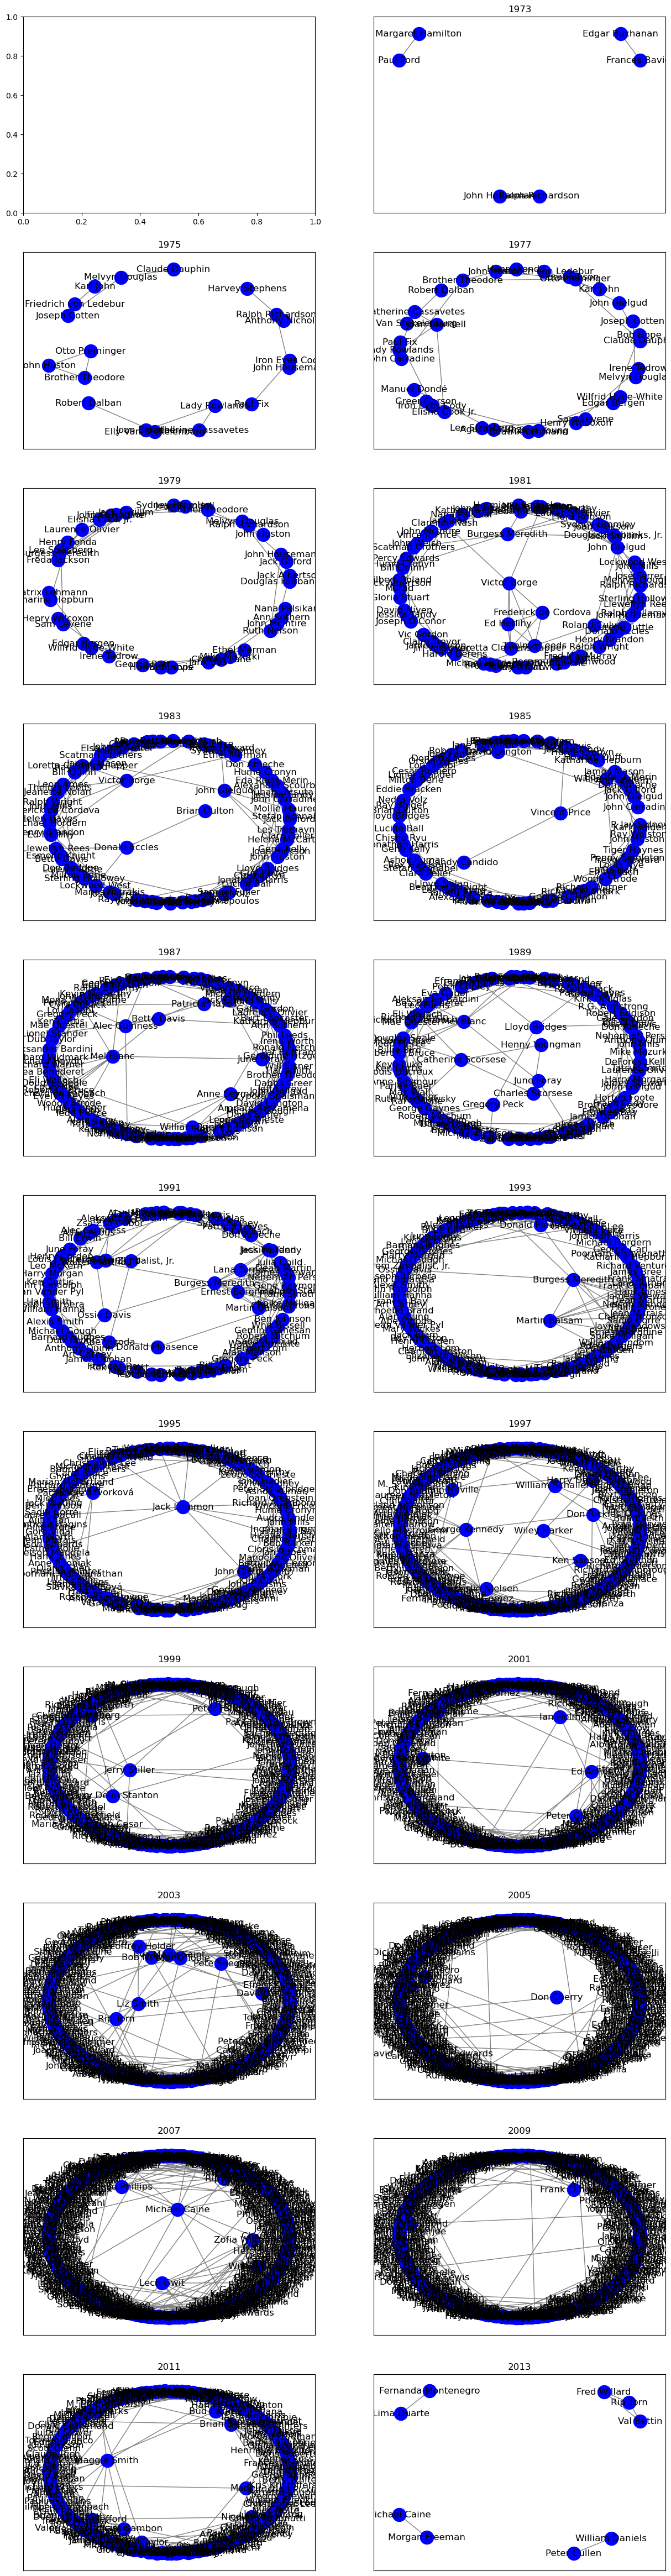

In [30]:
plot_dynamic_graph(g, start_year, stop_year, 2) # put a small step size